### 🚀 1. Setup & Memuat Data ###

In [1]:
# ====================================================================
# NOTEBOOK: train_model_jantung_NON_PCA.ipynb
# ====================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

# Import library untuk model dan preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb 

In [2]:
# Pastikan folder output ada
OUTPUT_FOLDER = 'hasil_jantung'
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
print(f"✅ Folder output '{OUTPUT_FOLDER}' siap.")

# Muat dataset bersih
try:
    # Menggunakan path 'data/df_cleaned_jantung.csv' sesuai yang Anda berikan di input
    # Jika file ini tidak ditemukan, pastikan path-nya benar atau gunakan 'heart_disease_cleaned.csv'
    # jika itu nama file yang benar di direktori yang sama.
    df = pd.read_csv('data/df_cleaned_jantung.csv')
    print("✅ Dataset bersih berhasil dimuat.")
    print(f"Bentuk data: {df.shape}")
except FileNotFoundError:
    print("❌ File 'data/df_cleaned_jantung.csv' tidak ditemukan. Pastikan path-nya benar atau file ada.")
    exit()


✅ Folder output 'hasil_jantung' siap.
✅ Dataset bersih berhasil dimuat.
Bentuk data: (299, 14)


In [3]:
# ### 📊 2. Pemisahan Fitur dan Target ###
X = df.drop('target', axis=1)
y = df['target']

# Pisahkan data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("✅ Data berhasil dipisah menjadi training dan testing set.")

# Tentukan kolom numerik dan kategorikal
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

missing_num_cols = [col for col in numerical_cols if col not in X.columns]
if missing_num_cols:
    print(f"Peringatan: Kolom numerik {missing_num_cols} tidak ditemukan di data.")
    numerical_cols = [col for col in numerical_cols if col in X.columns]

missing_cat_cols = [col for col in categorical_cols if col not in X.columns]
if missing_cat_cols:
    print(f"Peringatan: Kolom kategorikal {missing_cat_cols} tidak ditemukan di data.")
    categorical_cols = [col for col in categorical_cols if col in X.columns]



✅ Data berhasil dipisah menjadi training dan testing set.


### ⚙️ 3. Pra-pemrosesan Data dengan Pipeline & GridSearchCV (Otomatisasi Pemilihan Scaler) ###

In [4]:
# Preprocessor dasar (akan digunakan untuk model "sebelum optimasi" dan sebagai dasar GridSearchCV)
base_preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols), # 'passthrough' akan diganti oleh scaler di GridSearch
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Definisikan model yang ingin Anda uji (sesuai permintaan: 4 algoritma)
models = {
    'LogisticRegression': LogisticRegression(random_state=42, solver='liblinear'),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'SVC': SVC(random_state=42, probability=True),
    'XGBClassifier': xgb.XGBClassifier(random_state=42, eval_metric='logloss')
}

# Definisikan scaler yang akan diuji
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'No Scaling': 'passthrough' # Untuk kasus tanpa scaling
}

# Definisikan parameter grid untuk setiap model dan scaler
param_grid_base = {
    'LogisticRegression': {
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2']
    },
    'RandomForestClassifier': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20]
    },
    'SVC': {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['rbf', 'linear']
    },
    'XGBClassifier': {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7]
    }
}

# --- Fungsi untuk plot Confusion Matrix ---
def plot_confusion_matrix(y_true, y_pred, title, filename, output_folder):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Prediksi Negatif (0)', 'Prediksi Positif (1)'],
                yticklabels=['Aktual Negatif (0)', 'Aktual Positif (1)'])
    plt.title(title)
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.text(0.5, -0.2, "TN: True Negative, FP: False Positive\nFN: False Negative, TP: True Positive",
             horizontalalignment='center', verticalalignment='top', transform=plt.gca().transAxes, fontsize=9)
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, filename))
    plt.close() # Tutup plot agar tidak ditampilkan di output jika banyak plot

### 📊 4. Evaluasi Model Sebelum Optimasi & Confusion Matrix ###


--- Evaluasi Model Sebelum Optimasi (Default Parameters, StandardScaler) ---

Melatih dan mengevaluasi model default: LogisticRegression
Akurasi Default (LogisticRegression): 0.8167


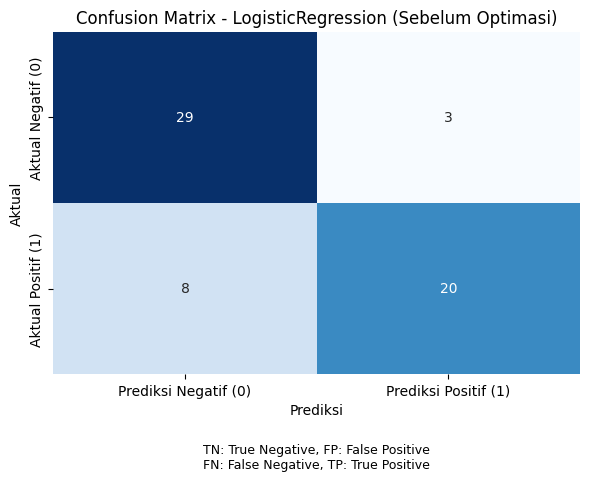

✅ Confusion Matrix untuk LogisticRegression (Sebelum Optimasi) disimpan dan ditampilkan.

Melatih dan mengevaluasi model default: RandomForestClassifier
Akurasi Default (RandomForestClassifier): 0.7833


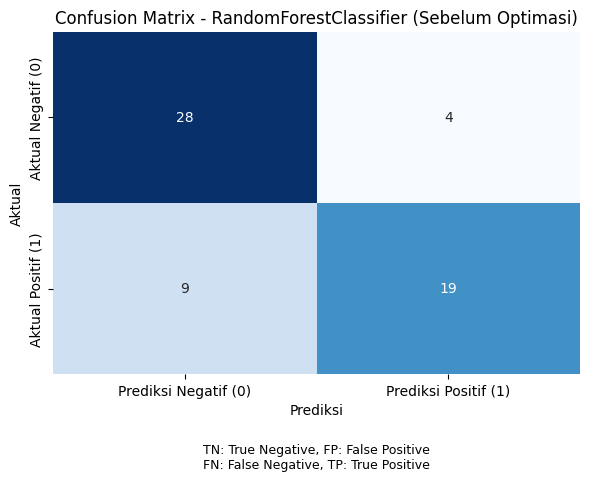

✅ Confusion Matrix untuk RandomForestClassifier (Sebelum Optimasi) disimpan dan ditampilkan.

Melatih dan mengevaluasi model default: SVC
Akurasi Default (SVC): 0.8333


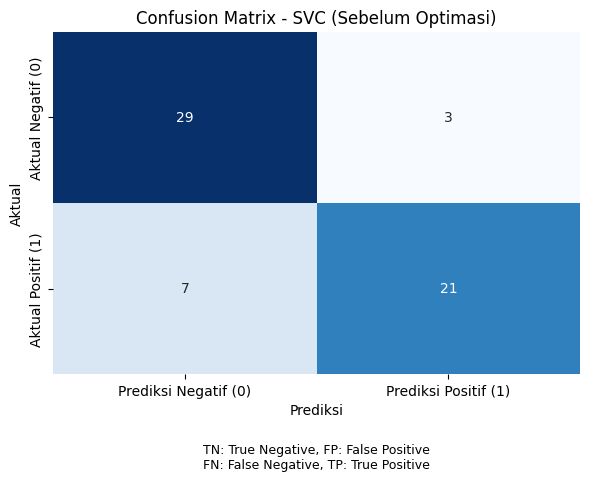

✅ Confusion Matrix untuk SVC (Sebelum Optimasi) disimpan dan ditampilkan.

Melatih dan mengevaluasi model default: XGBClassifier
Akurasi Default (XGBClassifier): 0.8167


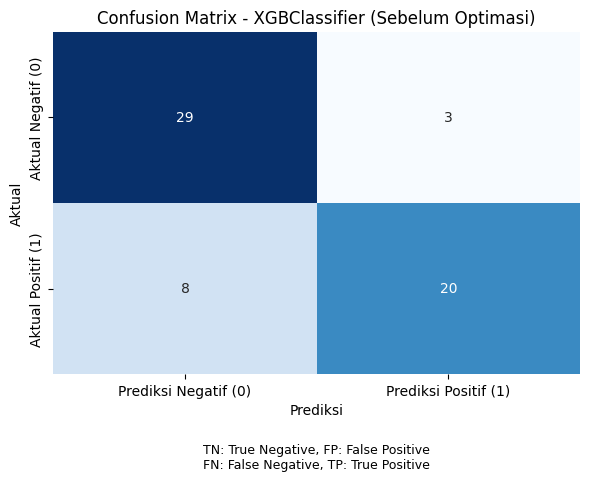

✅ Confusion Matrix untuk XGBClassifier (Sebelum Optimasi) disimpan dan ditampilkan.


In [5]:
# --- Fungsi untuk plot Confusion Matrix ---
def plot_confusion_matrix(y_true, y_pred, title, filename, output_folder):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Prediksi Negatif (0)', 'Prediksi Positif (1)'],
                yticklabels=['Aktual Negatif (0)', 'Aktual Positif (1)'])
    plt.title(title)
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.text(0.5, -0.2, "TN: True Negative, FP: False Positive\nFN: False Negative, TP: True Positive",
             horizontalalignment='center', verticalalignment='top', transform=plt.gca().transAxes, fontsize=9)
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, filename))
    plt.show() # Ditampilkan setelah disimpan
    # plt.close() # Baris ini dihapus agar plot tetap ditampilkan setelah disimpan

# ### 📊 4. Evaluasi Model Sebelum Optimasi & Confusion Matrix ###
print("\n--- Evaluasi Model Sebelum Optimasi (Default Parameters, StandardScaler) ---")
unoptimized_models = {}
default_preprocessor_for_unoptimized = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols), # Menggunakan StandardScaler sebagai default
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

for model_name, model in models.items():
    print(f"\nMelatih dan mengevaluasi model default: {model_name}")
    pipeline_default = Pipeline(steps=[
        ('preprocessor', default_preprocessor_for_unoptimized),
        ('classifier', model)
    ])
    pipeline_default.fit(X_train, y_train)
    y_pred_default = pipeline_default.predict(X_test)
    unoptimized_models[model_name] = pipeline_default # Simpan model default

    accuracy_default = accuracy_score(y_test, y_pred_default)
    print(f"Akurasi Default ({model_name}): {accuracy_default:.4f}")

    # Plot Confusion Matrix sebelum optimasi
    plot_confusion_matrix(y_test, y_pred_default,
                          title=f'Confusion Matrix - {model_name} (Sebelum Optimasi)',
                          filename=f'cm_before_optimization_{model_name.lower()}.png',
                          output_folder=OUTPUT_FOLDER)
    print(f"✅ Confusion Matrix untuk {model_name} (Sebelum Optimasi) disimpan dan ditampilkan.")


### ⚙️ 5. Pra-pemrosesan Data dengan Pipeline & GridSearchCV (Otomatisasi Pemilihan Scaler & Optimasi Model) ###

In [6]:
best_models = {}
results = []
all_grid_results = [] # Untuk menyimpan semua hasil GridSearch (termasuk kombinasi scaler)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n🚀 Memulai pencarian model dan scaler terbaik menggunakan GridSearchCV...")

for model_name, model in models.items(): # Loop hanya untuk 4 model yang dipilih
    print(f"\n--- Menguji model: {model_name} ---")

    current_param_grid = param_grid_base[model_name].copy()
    current_param_grid['preprocessor__num'] = list(scalers.values())

    pipeline = Pipeline(steps=[
        ('preprocessor', base_preprocessor), # Gunakan base_preprocessor yang placeholder untuk num
        ('classifier', model)
    ])

    grid_search = GridSearchCV(
        pipeline,
        param_grid=current_param_grid,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )
    grid_search.fit(X_train, y_train)

    best_estimator = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    best_scaler_instance = best_estimator.named_steps['preprocessor'].named_transformers_['num']
    best_scaler_name = best_scaler_instance.__class__.__name__ if hasattr(best_scaler_instance, '__class__') and best_scaler_instance != 'passthrough' else 'No Scaling'

    print(f"✅ Model terbaik untuk {model_name}:")
    print(f"   Parameter Terbaik: {best_params}")
    print(f"   Scaler Terbaik: {best_scaler_name}")
    print(f"   Skor Akurasi CV Terbaik: {best_score:.4f}")

    y_pred = best_estimator.predict(X_test)
    y_proba = best_estimator.predict_proba(X_test)[:, 1] if hasattr(best_estimator, 'predict_proba') else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    print(f"   Akurasi pada Test Set: {accuracy:.4f}")
    print(f"   Presisi pada Test Set: {precision:.4f}")
    print(f"   Recall pada Test Set: {recall:.4f}")
    print(f"   F1-Score pada Test Set: {f1:.4f}")
    if y_proba is not None:
        print(f"   ROC AUC pada Test Set: {roc_auc:.4f}")

    best_models[model_name] = best_estimator # Simpan estimator terbaik

    results.append({
        'Model': model_name,
        'Best Scaler': best_scaler_name,
        'Best CV Score (Accuracy)': best_score,
        'Test Accuracy': accuracy,
        'Test Precision': precision,
        'Test Recall': recall,
        'Test F1-Score': f1,
        'Test ROC AUC': roc_auc
    })

    # Simpan semua hasil dari GridSearch untuk visualisasi perbandingan scaler
    grid_results_df = pd.DataFrame(grid_search.cv_results_)
    grid_results_df['model_name'] = model_name
    all_grid_results.append(grid_results_df)

# Konversi hasil ke DataFrame untuk tampilan yang lebih baik
results_df = pd.DataFrame(results)
print("\n=== Ringkasan Hasil Perbandingan Model dan Scaler Terbaik (Setelah Optimasi) ===")
print(results_df.sort_values(by='Test F1-Score', ascending=False))

# Gabungkan semua hasil GridSearch untuk visualisasi perbandingan scaler yang lebih detail
all_grid_results_df = pd.concat(all_grid_results, ignore_index=True)





🚀 Memulai pencarian model dan scaler terbaik menggunakan GridSearchCV...

--- Menguji model: LogisticRegression ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits
✅ Model terbaik untuk LogisticRegression:
   Parameter Terbaik: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'preprocessor__num': StandardScaler()}
   Scaler Terbaik: StandardScaler
   Skor Akurasi CV Terbaik: 0.8660
   Akurasi pada Test Set: 0.8333
   Presisi pada Test Set: 0.8750
   Recall pada Test Set: 0.7500
   F1-Score pada Test Set: 0.8077
   ROC AUC pada Test Set: 0.9319

--- Menguji model: RandomForestClassifier ---
Fitting 5 folds for each of 36 candidates, totalling 180 fits
✅ Model terbaik untuk RandomForestClassifier:
   Parameter Terbaik: {'classifier__max_depth': None, 'classifier__n_estimators': 50, 'preprocessor__num': StandardScaler()}
   Scaler Terbaik: StandardScaler
   Skor Akurasi CV Terbaik: 0.8409
   Akurasi pada Test Set: 0.8000
   Presisi pada Test Set: 0.8333
   Recall pada Te

### 📊 6. Visualisasi Confusion Matrix Setelah Optimasi ###


--- Visualisasi Confusion Matrix Setelah Optimasi ---


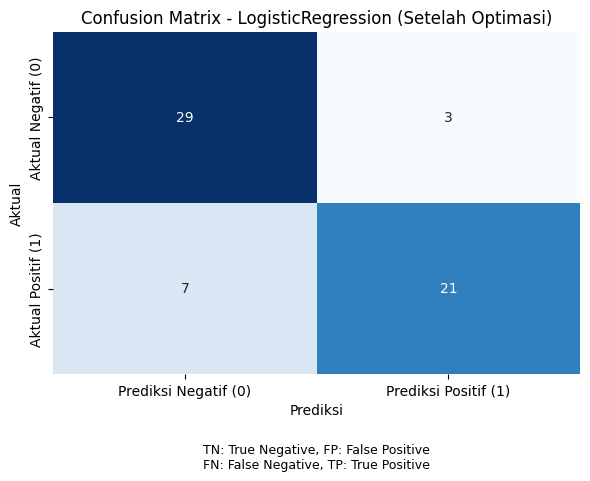

✅ Confusion Matrix untuk LogisticRegression (Setelah Optimasi) disimpan.


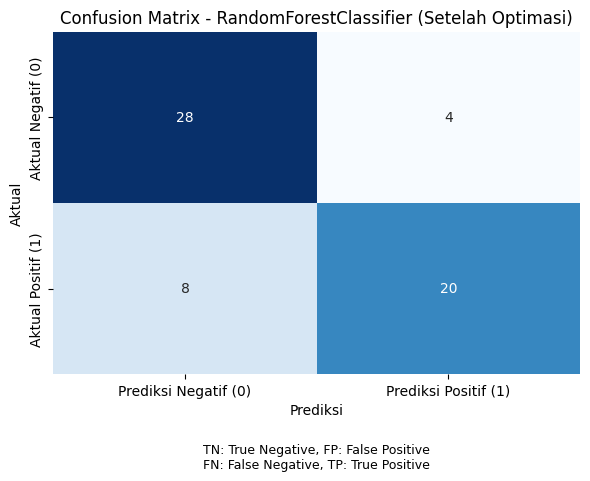

✅ Confusion Matrix untuk RandomForestClassifier (Setelah Optimasi) disimpan.


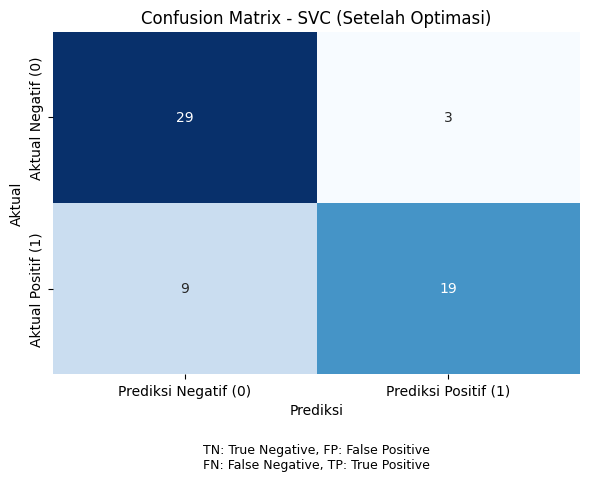

✅ Confusion Matrix untuk SVC (Setelah Optimasi) disimpan.


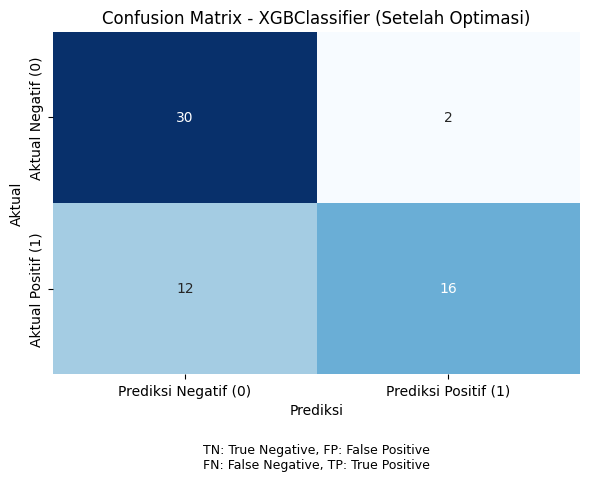

✅ Confusion Matrix untuk XGBClassifier (Setelah Optimasi) disimpan.


In [7]:
print("\n--- Visualisasi Confusion Matrix Setelah Optimasi ---")
for model_name, best_estimator in best_models.items():
    y_pred_optimized = best_estimator.predict(X_test)
    plot_confusion_matrix(y_test, y_pred_optimized,
                          title=f'Confusion Matrix - {model_name} (Setelah Optimasi)',
                          filename=f'cm_after_optimization_{model_name.lower()}.png',
                          output_folder=OUTPUT_FOLDER)
    print(f"✅ Confusion Matrix untuk {model_name} (Setelah Optimasi) disimpan.")

### 📊 7. Visualisasi Hasil Perbandingan Normalisasi Data (Semua Kombinasi Scaler) ###

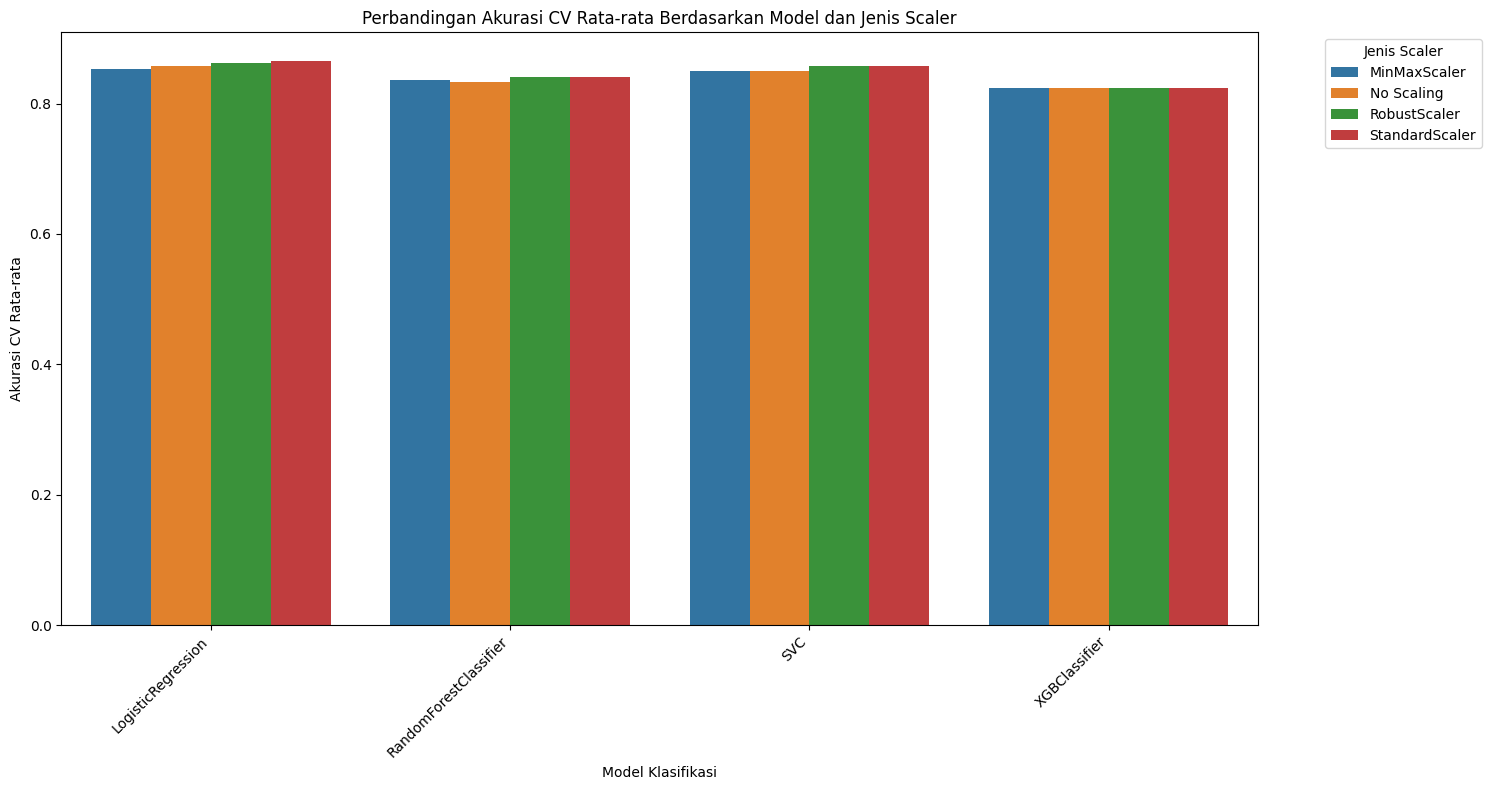

In [8]:
# Buat kolom 'Scaler Name' yang lebih mudah dibaca
all_grid_results_df['Scaler Name'] = all_grid_results_df['param_preprocessor__num'].apply(
    lambda x: x.__class__.__name__ if hasattr(x, '__class__') and x != 'passthrough' else 'No Scaling'
)

# Filter hanya baris yang relevan untuk setiap kombinasi scaler dan model
scaler_comparison_data = all_grid_results_df.groupby(['model_name', 'Scaler Name'])['mean_test_score'].max().reset_index()
scaler_comparison_data.rename(columns={'mean_test_score': 'Mean CV Accuracy'}, inplace=True)


plt.figure(figsize=(15, 8))
sns.barplot(x='model_name', y='Mean CV Accuracy', hue='Scaler Name', data=scaler_comparison_data)
plt.title('Perbandingan Akurasi CV Rata-rata Berdasarkan Model dan Jenis Scaler')
plt.ylabel('Akurasi CV Rata-rata')
plt.xlabel('Model Klasifikasi')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Jenis Scaler', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, 'perbandingan_akurasi_scaler_model.png'))
plt.show()

### 💾 8. Menyimpan Model Terbaik Keseluruhan ###

In [9]:
best_overall_model_row = results_df.loc[results_df['Test F1-Score'].idxmax()]
best_overall_model_name = best_overall_model_row['Model']
best_overall_pipeline = best_models[best_overall_model_name]

print(f"\nModel terbaik keseluruhan (berdasarkan F1-Score) adalah: {best_overall_model_name}")
print(f"Menggunakan scaler: {best_overall_model_row['Best Scaler']}")

model_filename = os.path.join(OUTPUT_FOLDER, 'best_heart_disease_model_non_pca.pkl')
with open(model_filename, 'wb') as file:
    pickle.dump(best_overall_pipeline, file)
print(f"✅ Model terbaik keseluruhan berhasil disimpan sebagai '{model_filename}'")


Model terbaik keseluruhan (berdasarkan F1-Score) adalah: LogisticRegression
Menggunakan scaler: StandardScaler
✅ Model terbaik keseluruhan berhasil disimpan sebagai 'hasil_jantung\best_heart_disease_model_non_pca.pkl'


### 💾 9. Menyimpan Data Uji untuk Evaluasi Terpisah ###

In [10]:
X_test_path = os.path.join(OUTPUT_FOLDER, 'X_test_non_pca.csv')
y_test_path = os.path.join(OUTPUT_FOLDER, 'y_test_non_pca.csv')

X_test.to_csv(X_test_path, index=False)
y_test.to_csv(y_test_path, index=False)

print(f"\n✅ Data uji ({os.path.basename(X_test_path)} dan {os.path.basename(y_test_path)}) berhasil disimpan di '{OUTPUT_FOLDER}'.")


✅ Data uji (X_test_non_pca.csv dan y_test_non_pca.csv) berhasil disimpan di 'hasil_jantung'.
